In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import time as tm

# Import modules containing classes and functions needed for the simulation
from src.model_ctrl import RenG, gain
from src.model_sys import RobotsSystem, disturbance, computePriccati
from src.plots import plot_trajectories, plot_traj_vs_time
from src.loss_functions import f_loss_states, f_loss_u, f_loss_ca, f_loss_obst
from src.utils import set_params_online

# Set the random seed for reproducibility
torch.manual_seed(69)
# Set the parameters and hyperparameters for the simulation
params = set_params_online()
min_dist, t_end, n_agents, x0, xbar, learning_rate, epochs, Q, alpha_u, alpha_ca, alpha_obst, n_xi, \
        l, n_traj, std_ini, gamma_bar, wmax, decayw,maxtimew, Horizon, timeInstantOpt, sim_time, gainF, n_traj_ol = params

In [2]:
###########################################
# Define the system model
syst = RobotsSystem(xbar)
###########################################
# Define the controller model
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
amplifier = gain(gamma_bar)
ctl.load_state_dict(torch.load("trained_models/offline_mountains_ctl.pt", weights_only=False))
ctl.set_param()
amplifier.load_state_dict(torch.load("trained_models/offline_mountains_amp.pt", weights_only=False))

# Define the optimizer and its parameters{'params': OLs.parameters(), 'lr': 1e-3},
optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate)

Text(0.5, 1.0, 'closed loop disturbance w')

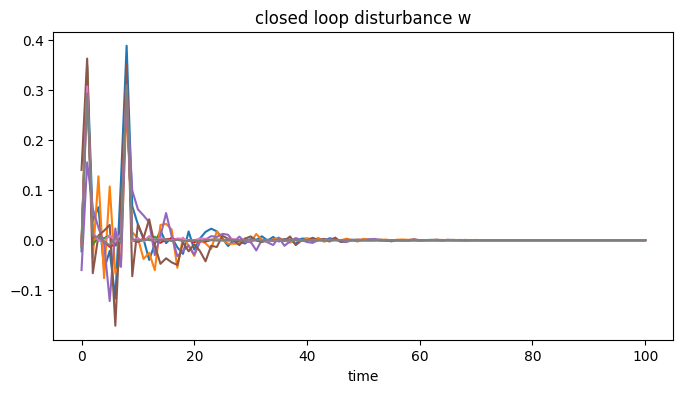

In [3]:
gamma_bar = amplifier.gamma.detach()

time = torch.linspace(0, sim_time, sim_time+1)

delta = 0.3
wmaxCL = wmax
w_inCL = torch.randn(sim_time + 1, syst.n)
w_in_CL = disturbance(time,w_inCL,wmax,decayw,maxtimew)
w_in_CL[1,:]= w_in_CL[1,:]+delta
w_in_CL[8,:]=w_in_CL[8,:]+delta

plt.figure(figsize=(4 * 2, 4))
plt.plot(time, w_in_CL)
plt.xlabel('time')
plt.title('closed loop disturbance w')
#plt.show()

------- Print pre-trained loop trajectories --------


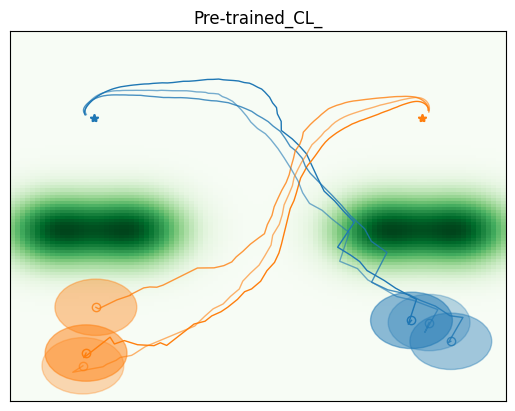

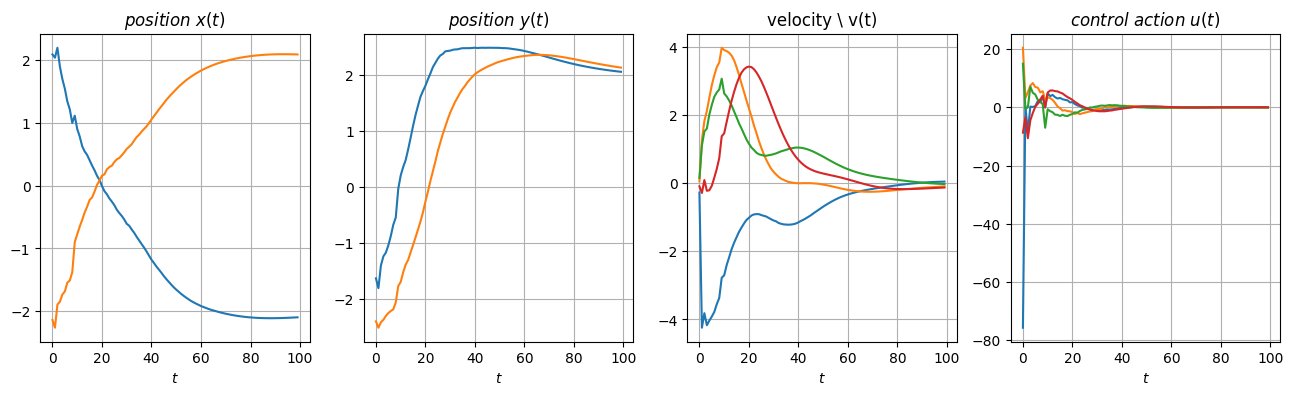

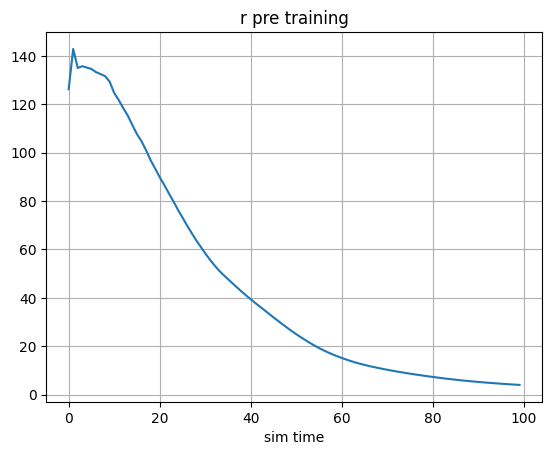

In [4]:
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print pre-trained loop trajectories --------")
# Generate random initial conditions for the trajectories
x_log_pre = torch.zeros(sim_time, syst.n,n_traj_ol)
u_log_pre = torch.zeros(sim_time, syst.m,n_traj_ol)
r_log_pre = torch.zeros(sim_time, 1)

for traj in range(n_traj_ol):
    devx0 = std_ini * torch.randn(x0.shape)
    w_in = torch.randn(sim_time + 1, syst.n)
    x = x0 + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0 - syst.xbar +devx0
    u, xi = ctl(0, w_REN, xi)
    usys = gamma_bar * u
    for t in range(sim_time):
        x_ = x
        if traj == 0:
            eps_pre = torch.norm(x-xbar)
            r_log_pre[t,:] = eps_pre.detach()*gainF*(gamma_bar+1)
        x_log_pre[t, :,traj] = x.detach()
        u_log_pre[t, :,traj] = usys.detach()
        w_syst = disturbance(t,w_in[t,:],wmaxCL,decayw,maxtimew)
        if t == 1 or t == 8:
            w_syst = w_syst + delta
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys)
        u, xi = ctl(t, w_REN, xi)
        usys = gamma_bar * u

plot_trajectories(x_log_pre, xbar, syst.n_agents, text="Pre-trained_CL_",save=False, filename="trajectories" ,circles=True, T=sim_time-1, obst=alpha_obst)
plot_traj_vs_time(sim_time, syst.n_agents, x_log_pre[:,:,-1], u_log_pre[:,:,-1])

plt.plot(time[:-1], r_log_pre[:,:].detach())
plt.xlabel(r'sim time')
plt.title(r'r pre training')
plt.grid()
plt.show()


In [5]:
# # # # # # # # Train # # # # # # # #
# Train the controller using the NeurSLS algorithm
print("------------ Begin training ------------")
print("Problem: RH neurSLS -- t_end: %i" % t_end + " -- lr: %.2e" % learning_rate +
      " -- epochs: %i" % epochs + " -- n_traj: %i" % n_traj_ol + " -- std_ini: %.2f" % std_ini)
print(" -- alpha_u: %.1f" % alpha_u + " -- alpha_ca: %i" % alpha_ca + " -- alpha_obst: %.1e" % alpha_obst)
print("REN info -- n_xi: %i" % n_xi + " -- l: %i" % l)
print("RH info -- Horizon: %i" % Horizon)
print("--------- --------- ---------  ---------")


r = 3*(r_log_pre[:,:].detach())


# Loop for the simulation
loss_trained = np.zeros(sim_time+1)
gain_log = torch.zeros(sim_time+1,1)
eps_log = torch.zeros(sim_time+1,1)

xiOR = ctl.x0

------------ Begin training ------------
Problem: RH neurSLS -- t_end: 100 -- lr: 1.00e-02 -- epochs: 400 -- n_traj: 3 -- std_ini: 0.20
 -- alpha_u: 0.0 -- alpha_ca: 100 -- alpha_obst: 5.0e+03
REN info -- n_xi: 5 -- l: 5
RH info -- Horizon: 25
--------- --------- ---------  ---------


Epoch: 0 --- Loss: 175543.2812 ---||--- Loss x: 150664.55 --- Loss u: 25.67 --- Loss ca: 128.08 --- Loss obst: 24724.98 Simulation time: 0 
Epoch: 1 --- Loss: 133932.0781 ---||--- Loss x: 101802.88 --- Loss u: 5.61 --- Loss ca: 167.17 --- Loss obst: 31956.41 Simulation time: 0 
Epoch: 2 --- Loss: 128240.0938 ---||--- Loss x: 92946.09 --- Loss u: 7.92 --- Loss ca: 185.34 --- Loss obst: 35100.74 Simulation time: 0 
Epoch: 3 --- Loss: 131524.4062 ---||--- Loss x: 85473.39 --- Loss u: 8.61 --- Loss ca: 145.99 --- Loss obst: 45896.41 Simulation time: 0 
Epoch: 4 --- Loss: 126765.2188 ---||--- Loss x: 85043.50 --- Loss u: 6.94 --- Loss ca: 206.61 --- Loss obst: 41508.17 Simulation time: 0 
Epoch: 5 --- Loss: 118995.3281 ---||--- Loss x: 86122.98 --- Loss u: 6.51 --- Loss ca: 126.40 --- Loss obst: 32739.44 Simulation time: 0 
Epoch: 6 --- Loss: 108995.6875 ---||--- Loss x: 87271.34 --- Loss u: 6.46 --- Loss ca: 56.86 --- Loss obst: 21661.03 Simulation time: 0 
Epoch: 7 --- Loss: 115789.7188 -

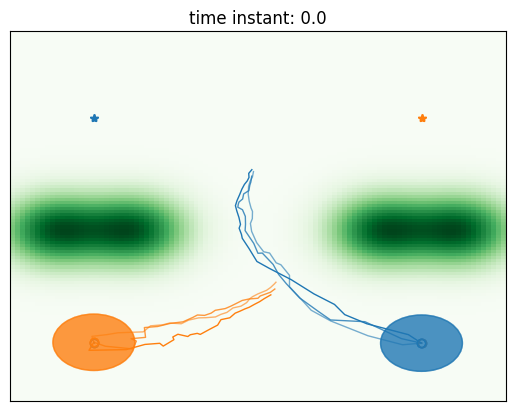

Epoch: 0 --- Loss: 150364.0469 ---||--- Loss x: 112544.27 --- Loss u: 11.30 --- Loss ca: 118.89 --- Loss obst: 37689.59 Simulation time: 1 
Epoch: 1 --- Loss: 130184.6953 ---||--- Loss x: 105141.34 --- Loss u: 13.61 --- Loss ca: 91.54 --- Loss obst: 24938.20 Simulation time: 1 
Epoch: 2 --- Loss: 106331.5312 ---||--- Loss x: 93393.17 --- Loss u: 15.54 --- Loss ca: 170.03 --- Loss obst: 12752.79 Simulation time: 1 
Epoch: 3 --- Loss: 97869.3828 ---||--- Loss x: 85588.22 --- Loss u: 21.15 --- Loss ca: 126.43 --- Loss obst: 12133.58 Simulation time: 1 
Epoch: 4 --- Loss: 87528.9609 ---||--- Loss x: 83340.43 --- Loss u: 28.34 --- Loss ca: 141.37 --- Loss obst: 4018.83 Simulation time: 1 
Epoch: 5 --- Loss: 82009.0625 ---||--- Loss x: 77912.01 --- Loss u: 34.78 --- Loss ca: 197.19 --- Loss obst: 3865.09 Simulation time: 1 
Epoch: 6 --- Loss: 75317.7578 ---||--- Loss x: 71878.91 --- Loss u: 39.11 --- Loss ca: 81.75 --- Loss obst: 3317.98 Simulation time: 1 
Epoch: 7 --- Loss: 71564.7031 ---|

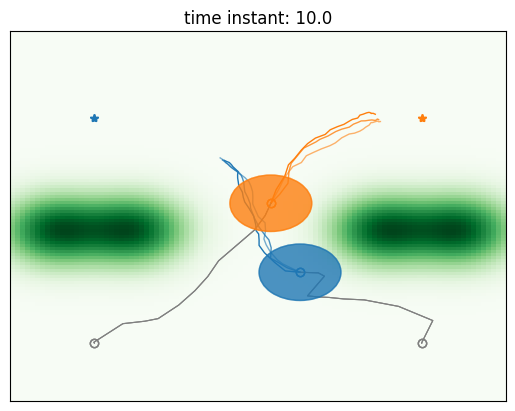

Epoch: 0 --- Loss: 68162.5312 ---||--- Loss x: 16220.81 --- Loss u: 3.19 --- Loss ca: 26542.49 --- Loss obst: 25396.04 Simulation time: 12 
Epoch: 1 --- Loss: 49996.6250 ---||--- Loss x: 14184.21 --- Loss u: 2.99 --- Loss ca: 18671.35 --- Loss obst: 17138.07 Simulation time: 12 
Epoch: 2 --- Loss: 36994.5078 ---||--- Loss x: 13216.95 --- Loss u: 3.04 --- Loss ca: 10241.84 --- Loss obst: 13532.68 Simulation time: 12 
Epoch: 3 --- Loss: 40491.1797 ---||--- Loss x: 13245.53 --- Loss u: 3.20 --- Loss ca: 10217.02 --- Loss obst: 17025.44 Simulation time: 12 
Epoch: 4 --- Loss: 37588.5039 ---||--- Loss x: 13602.15 --- Loss u: 3.34 --- Loss ca: 9311.06 --- Loss obst: 14671.95 Simulation time: 12 
Epoch: 5 --- Loss: 30776.1602 ---||--- Loss x: 12714.08 --- Loss u: 3.87 --- Loss ca: 7050.08 --- Loss obst: 11008.13 Simulation time: 12 
Epoch: 6 --- Loss: 29032.6875 ---||--- Loss x: 12974.96 --- Loss u: 3.96 --- Loss ca: 8448.93 --- Loss obst: 7604.84 Simulation time: 12 
Epoch: 7 --- Loss: 27006

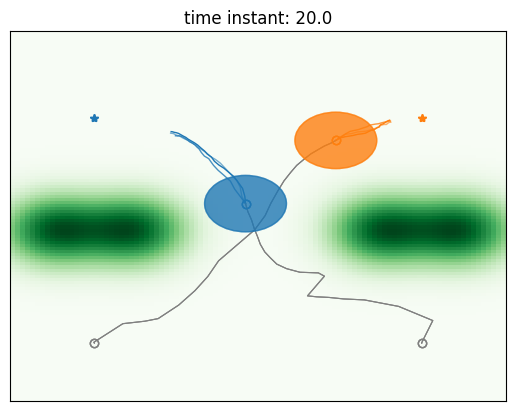

Epoch: 0 --- Loss: 4322.4946 ---||--- Loss x: 3366.09 --- Loss u: 0.70 --- Loss ca: 410.62 --- Loss obst: 545.09 Simulation time: 22 
Epoch: 1 --- Loss: 4550.8662 ---||--- Loss x: 3813.56 --- Loss u: 0.50 --- Loss ca: 457.37 --- Loss obst: 279.44 Simulation time: 22 
Epoch: 2 --- Loss: 4487.8223 ---||--- Loss x: 3707.14 --- Loss u: 0.70 --- Loss ca: 523.90 --- Loss obst: 256.07 Simulation time: 22 
Epoch: 3 --- Loss: 4219.1689 ---||--- Loss x: 3401.01 --- Loss u: 1.05 --- Loss ca: 523.04 --- Loss obst: 294.07 Simulation time: 22 
Epoch: 4 --- Loss: 4364.1650 ---||--- Loss x: 3242.34 --- Loss u: 1.37 --- Loss ca: 554.22 --- Loss obst: 566.23 Simulation time: 22 
Epoch: 5 --- Loss: 4217.0698 ---||--- Loss x: 3124.77 --- Loss u: 1.67 --- Loss ca: 465.94 --- Loss obst: 624.70 Simulation time: 22 
Epoch: 6 --- Loss: 4096.2422 ---||--- Loss x: 3074.21 --- Loss u: 2.13 --- Loss ca: 518.75 --- Loss obst: 501.15 Simulation time: 22 
Epoch: 7 --- Loss: 4170.6548 ---||--- Loss x: 3197.72 --- Loss

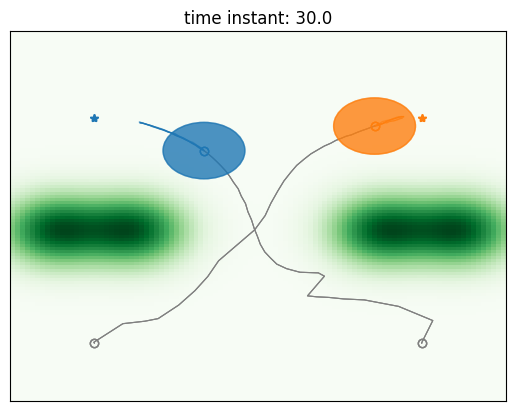

Epoch: 0 --- Loss: 1366.0986 ---||--- Loss x: 1246.72 --- Loss u: 0.09 --- Loss ca: 0.00 --- Loss obst: 119.29 Simulation time: 32 
Epoch: 1 --- Loss: 1512.3477 ---||--- Loss x: 1393.93 --- Loss u: 0.10 --- Loss ca: 0.00 --- Loss obst: 118.32 Simulation time: 32 
Epoch: 2 --- Loss: 1263.9352 ---||--- Loss x: 1188.80 --- Loss u: 0.07 --- Loss ca: 0.00 --- Loss obst: 75.06 Simulation time: 32 
Epoch: 3 --- Loss: 1419.0924 ---||--- Loss x: 1351.69 --- Loss u: 0.16 --- Loss ca: 0.00 --- Loss obst: 67.25 Simulation time: 32 
Epoch: 4 --- Loss: 1333.5190 ---||--- Loss x: 1256.36 --- Loss u: 0.13 --- Loss ca: 0.00 --- Loss obst: 77.03 Simulation time: 32 
Epoch: 5 --- Loss: 1269.7822 ---||--- Loss x: 1173.02 --- Loss u: 0.06 --- Loss ca: 0.00 --- Loss obst: 96.70 Simulation time: 32 
Epoch: 6 --- Loss: 1280.5011 ---||--- Loss x: 1159.75 --- Loss u: 0.05 --- Loss ca: 0.00 --- Loss obst: 120.70 Simulation time: 32 
Epoch: 7 --- Loss: 1321.4043 ---||--- Loss x: 1187.08 --- Loss u: 0.07 --- Loss 

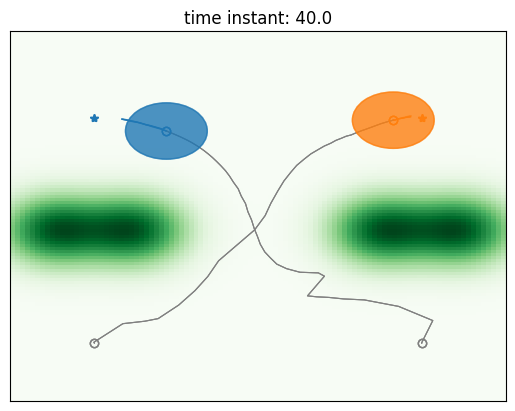

Epoch: 0 --- Loss: 509.8109 ---||--- Loss x: 458.21 --- Loss u: 0.03 --- Loss ca: 0.00 --- Loss obst: 51.57 Simulation time: 42 
Epoch: 1 --- Loss: 607.9644 ---||--- Loss x: 556.80 --- Loss u: 0.04 --- Loss ca: 0.00 --- Loss obst: 51.13 Simulation time: 42 
Epoch: 2 --- Loss: 493.3714 ---||--- Loss x: 446.78 --- Loss u: 0.02 --- Loss ca: 0.00 --- Loss obst: 46.57 Simulation time: 42 
Epoch: 3 --- Loss: 566.7415 ---||--- Loss x: 522.94 --- Loss u: 0.07 --- Loss ca: 0.00 --- Loss obst: 43.73 Simulation time: 42 
Epoch: 4 --- Loss: 529.0342 ---||--- Loss x: 487.07 --- Loss u: 0.05 --- Loss ca: 0.00 --- Loss obst: 41.91 Simulation time: 42 
Epoch: 5 --- Loss: 484.1010 ---||--- Loss x: 442.89 --- Loss u: 0.03 --- Loss ca: 0.00 --- Loss obst: 41.18 Simulation time: 42 
Epoch: 6 --- Loss: 494.2565 ---||--- Loss x: 452.61 --- Loss u: 0.02 --- Loss ca: 0.00 --- Loss obst: 41.62 Simulation time: 42 
Epoch: 7 --- Loss: 512.8347 ---||--- Loss x: 470.52 --- Loss u: 0.03 --- Loss ca: 0.00 --- Loss o

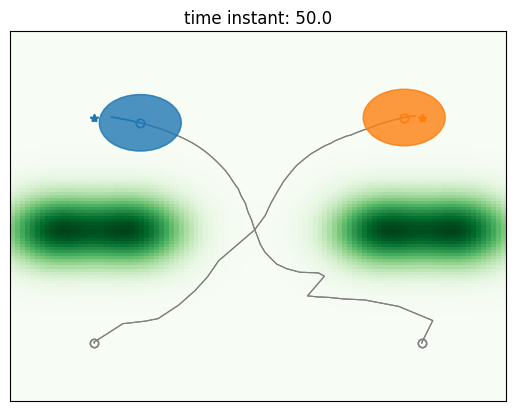

Epoch: 0 --- Loss: 221.3028 ---||--- Loss x: 189.57 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 31.72 Simulation time: 52 
Epoch: 1 --- Loss: 281.9768 ---||--- Loss x: 246.30 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 35.67 Simulation time: 52 
Epoch: 2 --- Loss: 212.0408 ---||--- Loss x: 180.10 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 31.93 Simulation time: 52 
Epoch: 3 --- Loss: 211.4259 ---||--- Loss x: 182.34 --- Loss u: 0.02 --- Loss ca: 0.00 --- Loss obst: 29.06 Simulation time: 52 
Epoch: 4 --- Loss: 224.6487 ---||--- Loss x: 197.79 --- Loss u: 0.03 --- Loss ca: 0.00 --- Loss obst: 26.83 Simulation time: 52 
Epoch: 5 --- Loss: 216.2194 ---||--- Loss x: 191.41 --- Loss u: 0.02 --- Loss ca: 0.00 --- Loss obst: 24.79 Simulation time: 52 
Epoch: 6 --- Loss: 205.2942 ---||--- Loss x: 180.84 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 24.44 Simulation time: 52 
Epoch: 7 --- Loss: 203.1275 ---||--- Loss x: 178.26 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss o

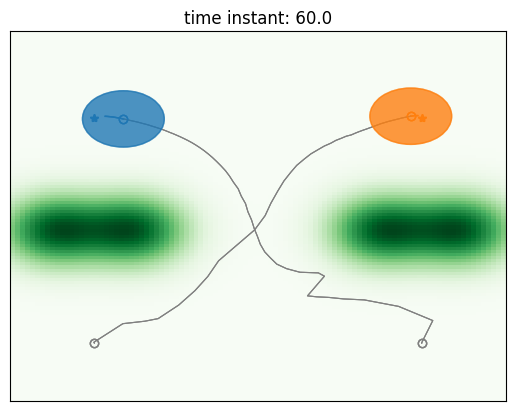

Epoch: 0 --- Loss: 99.2826 ---||--- Loss x: 75.23 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 24.05 Simulation time: 62 
Epoch: 1 --- Loss: 112.4006 ---||--- Loss x: 92.58 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 19.82 Simulation time: 62 
Epoch: 2 --- Loss: 103.6939 ---||--- Loss x: 80.28 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 23.41 Simulation time: 62 
Epoch: 3 --- Loss: 98.8561 ---||--- Loss x: 72.27 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 26.58 Simulation time: 62 
Epoch: 4 --- Loss: 95.5508 ---||--- Loss x: 68.66 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 26.88 Simulation time: 62 
Epoch: 5 --- Loss: 94.0179 ---||--- Loss x: 69.53 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 24.49 Simulation time: 62 
Epoch: 6 --- Loss: 93.3247 ---||--- Loss x: 71.15 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 22.17 Simulation time: 62 
Epoch: 7 --- Loss: 94.1632 ---||--- Loss x: 72.99 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 21.17 Sim

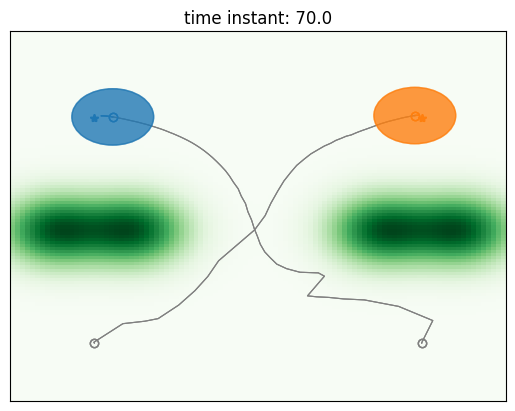

Epoch: 0 --- Loss: 53.7588 ---||--- Loss x: 33.03 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 20.72 Simulation time: 72 
Epoch: 1 --- Loss: 93.9971 ---||--- Loss x: 68.37 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 25.62 Simulation time: 72 
Epoch: 2 --- Loss: 53.6527 ---||--- Loss x: 31.69 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 21.97 Simulation time: 72 
Epoch: 3 --- Loss: 54.3766 ---||--- Loss x: 35.15 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 19.22 Simulation time: 72 
Epoch: 4 --- Loss: 60.6480 ---||--- Loss x: 42.43 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 18.21 Simulation time: 72 
Epoch: 5 --- Loss: 57.0452 ---||--- Loss x: 38.63 --- Loss u: 0.01 --- Loss ca: 0.00 --- Loss obst: 18.41 Simulation time: 72 
Epoch: 6 --- Loss: 52.1162 ---||--- Loss x: 32.76 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 19.36 Simulation time: 72 
Epoch: 7 --- Loss: 50.7856 ---||--- Loss x: 30.11 --- Loss u: 0.00 --- Loss ca: 0.00 --- Loss obst: 20.67 Simul

In [6]:
loss_trained = np.zeros(sim_time+1)
tOL = 0

# Data for log
ctlRH = None
x_log = torch.zeros(sim_time+1, syst.n)
u_log = torch.zeros(sim_time, syst.m)
w_in = torch.randn(sim_time + 1, syst.n)
gainM = gamma_bar
x = x0
if x.dtype is not torch.float:
    x = x.to(torch.float)
x_log[0, :] = x0.detach()
xi = torch.zeros(ctl.n)
w_REN = x0.detach() - syst.xbar
u, xi = ctl(0, w_REN, xi)
xiOR = ctl.x0
usys = gainM * u

for tsim in range(sim_time):
    # Compute the next state and control input using the systtem and controller models
    x_ = x
    u_log[tsim, :] = usys.detach()
    gain_log[tsim,:] = (r[tsim] / (gainF * torch.norm(x.detach()-xbar)))-1
    eps_log[tsim,:] = torch.norm(x.detach()-xbar)
    w_sys = disturbance(tsim,w_in_CL[tsim,:],wmaxCL,decayw,maxtimew)
    if tsim == 1 or tsim == 8:
        w_sys = w_sys + delta
    x = syst(tsim, x, usys, w_sys)
    x_log[tsim+1, :] = x.detach()
    w_est = x - syst.f(tsim, x_, usys)

    if (torch.max(w_est)>delta) or( (tsim % timeInstantOpt == 0) ):
        eps = torch.norm(x-syst.xbar)
        gainMt = (r[tsim] / (gainF * eps.detach()))-1
        if (gainMt.item() >0):
            gainM = gainMt
            x0t = x.detach()
            loss_list = np.zeros(epochs)
            if ctlRH is None:
                ctlRH = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
                ctlRH.load_state_dict(torch.load("trained_models/offline_mountains_ctl.pt", weights_only=False))
                ctlRH.set_param()
            state_dict = ctlRH.state_dict()
            state_dict['ctlRH.x0'] = xi.detach()
            ctlRH.set_param()
            optimizer = torch.optim.Adam([{'params': ctlRH.parameters()}], lr=learning_rate)
            for epoch in range(epochs):
                if epoch > 0:
                    del xt,w_int,xit,w_RENt,ut,usyst,loss
                # Reset the gradients of the optimizer
                optimizer.zero_grad()
                loss_x, loss_u, loss_ca, loss_obst = 0, 0, 0, 0
                # Loop over the specified number of trajectories
                xt_log = torch.zeros(Horizon, syst.n, n_traj_ol)
                ut_log = torch.zeros(Horizon, syst.m, n_traj_ol)
                for kk in range(n_traj_ol):
                    w_int = torch.randn((sim_time + Horizon+1, syst.n))
                    devx0 = std_ini * torch.zeros(x0.shape)
                    xt = x0t + devx0
                    xit = xi.detach()
                    w_RENt = x0t.detach() - syst.xbar + devx0
                    ut, xit = ctlRH(0, w_RENt, xit)
                    usyst = gainM * ut
                    for t in range(Horizon):
                        xt_ = xt
                        # Compute the next state and control input using the system and controller models
                        xt_log[t, :,kk] = xt.detach()
                        ut_log[t, :,kk] = usyst.detach()
                        w_syst = disturbance(tsim+t, w_int[tsim+t, :], wmax, decayw, maxtimew)
                        xt = syst(tsim+t, xt, usyst, w_syst)
                        w_RENt = xt - syst.f(tsim+t, xt_, usyst)
                        ut, xit = ctlRH(tsim+t, w_RENt, xit)
                        usyst = gainM * ut
                        # Compute the loss and its components for this time step
                        loss_x = loss_x + f_loss_states(t, xt, syst, Q)
                        loss_u = loss_u + alpha_u * f_loss_u(t, usyst)
                        loss_ca = loss_ca + alpha_ca * f_loss_ca(xt, syst, min_dist)
                        if alpha_obst != 0:
                            loss_obst = loss_obst + alpha_obst * f_loss_obst(xt)
                        if t == Horizon-1:
                            n_traj_tc = 1
                            t_end = sim_time - tsim
                            P = computePriccati(syst, 10*Q,alpha_u*torch.eye(syst.m))
                            loss_x = loss_x + f_loss_states(t, xt, syst, P)

                # Compute the total loss for this epoch and log its components
                loss = loss_x + loss_u + loss_ca + loss_obst
                print("Epoch: %i --- Loss: %.4f ---||--- Loss x: %.2f --- " % (epoch, loss, loss_x) +
                      "Loss u: %.2f --- Loss ca: %.2f --- Loss obst: %.2f" % (loss_u, loss_ca, loss_obst) +
                      " Simulation time: %i "% (tsim))
                loss_list[epoch] = loss.detach()

                # Backpropagate the loss through the controller model and update its parameters
                loss.backward(retain_graph=True)
                optimizer.step()
                ctlRH.set_param()

            if (tsim%10==0 and tsim<75):
                plot_trajectories(xt_log, xbar, syst.n_agents, text="time instant: %.1f" % (tsim),circles=True,  save=False, filename="CL_online Horizon: %.1f " %Horizon , T=Horizon, obst=alpha_obst, x_=x_log, T_=tsim+1, min_dist=min_dist)
            
            w_REN = x.detach() - syst.xbar
            xi = torch.zeros(ctl.n)
            u, xi = ctlRH(0, w_REN, xi)
            usys = gainM * u
        else:
            warnings.warn("gain NEGATIVO.", UserWarning)
            w_REN = x - syst.f(tsim, x_, usys)
            u, xi = ctlRH(0, w_REN, xi)
            usys = gainM * u
    else:
        w_REN = x - syst.f(tsim, x_, usys)
        u, xi = ctlRH(tsim, w_REN, xi)
        usys = gainM * u

    loss_trained[tsim+1] = loss_trained[tsim]+f_loss_states(tsim, x, syst, Q)+alpha_u * f_loss_u(tsim, usys)+alpha_ca * f_loss_ca(x, syst, min_dist)+ alpha_obst * f_loss_obst(x)

------- Print pre-trained loop trajectories --------


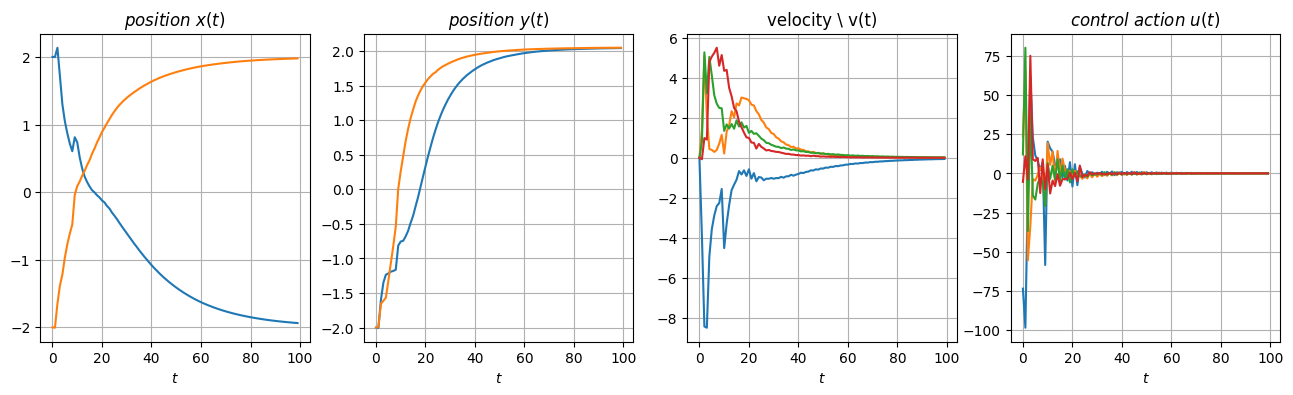

------- Print trained closed-loop trajectories --------


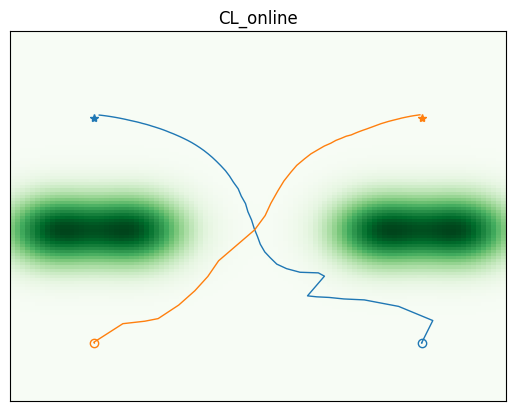

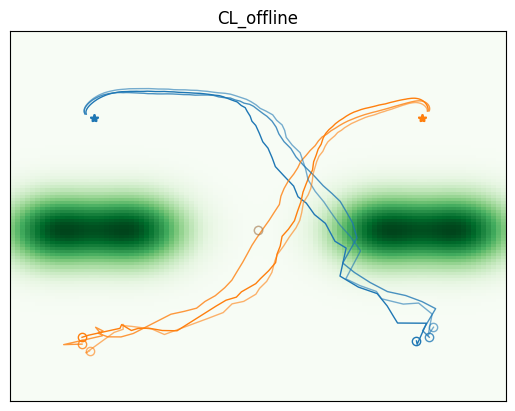

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 800x400 with 0 Axes>

In [7]:
# simulation with closed loop disturbance
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print pre-trained loop trajectories --------")
# Generate random initial conditions for the trajectories
x_log_pre = torch.zeros(sim_time, syst.n,n_traj_ol+1)
u_log_pre = torch.zeros(sim_time, syst.m,n_traj_ol+1)
loss_pretrained = np.zeros(sim_time+1)

for traj in range(n_traj_ol):
    devx0 = std_ini * torch.randn(x0.shape)
    w_in = torch.randn(sim_time + 1, syst.n)
    x = x0 + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0 - syst.xbar +devx0
    u, xi = ctl(0, w_REN, xi)
    usys = gamma_bar * u
    for t in range(sim_time):
        x_ = x
        if traj == 0:
            eps_pre = torch.norm(x-xbar)
            r_log_pre[t,:] = eps_pre.detach()*gainF*(gamma_bar+1)
        x_log_pre[t, :,traj] = x.detach()
        u_log_pre[t, :,traj] = usys.detach()
        w_syst = disturbance(t,w_in[t,:],wmaxCL,decayw,maxtimew)
        if t == 1 or t == 8:
            w_syst = w_syst + delta
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys)
        u, xi = ctl(t, w_REN, xi)
        usys = gamma_bar * u
        loss_x =  f_loss_states(t, x, syst, Q)
        loss_u = alpha_u * f_loss_u(t, usys)
        loss_ca = alpha_ca * f_loss_ca(x, syst, min_dist)
        if alpha_obst != 0:
            loss_obst =  alpha_obst * f_loss_obst(x)
        loss = loss_x + loss_u + loss_ca + loss_obst
        loss_pretrained[t+1] = loss.detach()

plot_traj_vs_time(sim_time, syst.n_agents, x_log[:-1,:], u_log)
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print trained closed-loop trajectories --------")
plot_trajectories(x_log[:,:], xbar, syst.n_agents, text="CL_online",save=False , T=sim_time, obst=alpha_obst)
plot_trajectories(x_log_pre[:,:], xbar, syst.n_agents, text="CL_offline",save=False, T=sim_time, obst=alpha_obst)

time = torch.linspace(0, sim_time, sim_time+1)
plt.figure(figsize=(4 * 2, 4))
plt.plot(time, loss_pretrained[:,-1].detach(), label="loss offline ")
plt.plot(time, loss_trained, label="loss online")
plt.show()
plt.legend()
plt.title('Comparison loss offline and online')